# Notices from interferometers GCN

I streamed from Kafka a number of recent notices from [LVC-GCN](https://gcn.gsfc.nasa.gov/lvc.html) and saved them to individual XML files. This resulted in a collection of ~2500 XML notice file.

In [1]:
from pathlib import Path
import re
import random; random.seed(10)
from random import choice
import xml.etree.ElementTree as ET


NOTICES_PATH = Path("/home/deppep/Dropbox/Progetti/LSST/gcn/kafka-lvc/notices")
FILENAME_PATTERN = r"voe_(.*?)_(\d+).xml"

events = {}
for file in NOTICES_PATH.iterdir():
    if not (match := re.match(FILENAME_PATTERN, file.name)):
        print(f"Cannot match {file.name}"); continue
    topic, offset = match.groups()
    events.setdefault(topic, []).append(int(offset))

print(f"got notices from topics {', '.join([*events.keys()])}.")

got notices from topics lvc_preliminary, lvc_initial, lvc_retraction, lvc_update, lvc_counterpart.


In [2]:
topic = "lvc_preliminary"
voe_random_path = NOTICES_PATH / f"voe_{topic}_{choice(events[topic])}.xml"
print(voe_random_path)
print(f"Selected notice '{voe_random_path.name}'.")

with open(voe_random_path, "r") as f:
    lines = f.readlines()
print("".join(lines))

/home/deppep/Dropbox/Progetti/LSST/gcn/kafka-lvc/notices/voe_lvc_preliminary_54869.xml
Selected notice 'voe_lvc_preliminary_54869.xml'.
<?xml version='1.0' encoding='UTF-8'?>
<voe:VOEvent xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:voe="http://www.ivoa.net/xml/VOEvent/v2.0" xsi:schemaLocation="http://www.ivoa.net/xml/VOEvent/v2.0 http://www.ivoa.net/xml/VOEvent/VOEvent-v2.0.xsd" version="2.0" role="test" ivorn="ivo://gwnet/LVC#MS250320r-2-Preliminary">
  <Who>
    <Date>2025-03-20T17:33:11Z</Date>
    <Author>
      <contactName>LIGO Scientific Collaboration, Virgo Collaboration, and KAGRA Collaboration</contactName>
    </Author>
  </Who>
  <What>
    <Param name="Packet_Type" value="150" dataType="int">
      <Description>The Notice Type number is assigned/used within GCN, eg type=150 is an LVC_PRELIMINARY notice</Description>
    </Param>
    <Param name="internal" value="0" dataType="int">
      <Description>Indicates whether this event should be distributed to LSC/

## LVC notice feature extractor

For parsing the XML content we use the same code we wrote for GBM-notices (imported here as `voeparser`). 

We write functions to extract a number of useful features from a single LVC notice.

In [3]:
from datetime import datetime, timezone
from typing import Generator

from voeparser import parse_notice



def _get_nested_key(
        notice: dict,
        name: str,
        key: str,
) -> dict:
    """
    Returns first nested 'key' matching `name` in notice.
    Returns empty dict if no match is found or if notice does not contain `key`.
    """
    if notice == {} or key not in notice:
        return {}
    param_list = notice[key]
    if not isinstance(param_list, list):
        param_list = [param_list]
    for param in param_list:
        if param["@name"] == name:
            return param
    return {}

def get_param(
        notice: dict,
        name: str
) -> dict:
    """
    Returns first parameter matching `name` in notice.
    Returns empty dict otherwise.
    """
    return _get_nested_key(notice, name, "Param")

def get_group(
        notice: dict,
        name: str
) -> dict:
    """
    Returns first group matching `name` in notice.
    Returns empty dict otherwise.
    """
    return _get_nested_key(notice, name, "Group")
.
def get_skymap_url(notice: dict) -> str | None:
    return get_param(get_group(notice["What"], "GW_SKYMAP"), "skymap_fits").get("@value", None)

def get_sernum(notice: dict) -> int | None:
    p = get_param(notice["What"], "Pkt_Ser_Num").get("@value", None)
    return int(p) if p is not None else p
    
def get_notice_time(notice: dict) -> datetime:
    dt = datetime.fromisoformat(notice["Who"]["Date"]["#text"])
    return dt


PATTERN_COORDS_SYSTEM_ID = r"(.*?)-(.*?)-(.*?)"


def _get_coords(notice: dict) -> dict:
    return notice["WhereWhen"]["ObsDataLocation"]["ObservationLocation"]["AstroCoords"]

def get_coordsys(notice: dict) -> tuple[str, str, str]:
    coords = _get_coords(notice)
    if match := re.match(PATTERN_COORDS_SYSTEM_ID, (_cs := coords["@coord_system_id"]), ):
        tz, frame, geo = match.groups()
    else:
        raise ValueError(f"Unknown coordinate system '{_cs.}'.")
    return tz, frame, geo

def get_obs_time(notice: dict) -> datetime:
    tz_str, _, _ = get_coordsys(notice)

    if tz_str == "UTC":
        tz = timezone.utc
    else:
        raise ValueError(f"Unknown time zone {tz_str}")

    coords = _get_coords(notice)
    dt = datetime.fromisoformat(coords["Time"]["TimeInstant"]["ISOTime"]["#text"])
    return dt.replace(tzinfo=tz)

SOURCES = [
    "BNS",
    "NSBH",
    "BBH",
    "Terrestrial",
]

def get_sources_likelihood(notice: dict) -> Generator:
    for (source, likelihood) in sorted([
        (s, get_param(get_group(notice["What"], "Classification"), s).get("@value", None))
            for s in [
                "BNS", 
                "NSBH", 
                "BBH", 
                "Terrestrial",
            ]
        ],
        key = lambda x: -float(x[1]) if x[1] is not None else +666,  # likelihood value are bound between 0 and 1.
    ):
        yield source, float(likelihood) if likelihood is not None else None
    return

def get_source_most_likely(notice: dict) -> tuple[str, float] | tuple[None, None]:
    source, llk = get_sources_likelihood(notice).__next__()
    if not llk:
        return None, None
    return source, llk

def get_grace_id(notice: dict) -> str:
    return get_param(notice["What"], "GraceID")["@value"]

def is_test(notice: dict) -> bool:
    return get_grace_id(notice).startswith("MS")

In [4]:
# test the funnctions above on the notices looking for errors
errors = {}
for filepath in NOTICES_PATH.iterdir():
    notice = parse_notice(filepath)
    for f in (fs := [
        get_skymap_url, 
        get_notice_time,
        get_sernum,
        get_coordsys,
        get_obs_time,
        get_source_most_likely,
        get_grace_id,
        is_test,
    ]):
        try:
            f(notice)
        except Exception as e:
            errors.setdefault(f.__name__, []).append(filepath.name)

print(f"Parsed {len([*NOTICES_PATH.iterdir()])} notices and run functions {', '.join(map(lambda x: x.__name__, fs))} on them with {len([e for k in errors for e in errors[k]])} errors. ")
if errors:
    print(f"Errors were raised on funcionts {', '.join(errors.keys())}")

Parsed 2557 notices and run functions get_skymap_url, get_notice_time, get_sernum, get_coordsys, get_obs_time, get_source_most_likely, get_grace_id, is_test on them with 0 errors. 


# LVC notice analysis

We create a dataframe table containing informations extracted from the notices.

In [5]:
import pandas as pd


def topic(filename: str):
    return re.match(FILENAME_PATTERN, filename).groups()[0]


filepaths = [f for f in NOTICES_PATH.iterdir()]
notices = [parse_notice(f) for f in filepaths]

filenames = [f.name for f in filepaths]
topics = [topic(fname) for fname in filenames]
notice_times = [get_notice_time(n) for n in notices]
obs_times = [get_obs_time(n) for n in notices]
skymaps = [get_skymap_url(n) for n in notices]
grace_ids = [get_grace_id(n) for n in notices]
sernum = [get_sernum(n) for n in notices]
istests = [is_test(n) for n in notices]
sourcellks = [get_source_most_likely(n) for n in notices]
sources, llks = zip(*sourcellks)
# computes delays
start_times = {}
for n in notices:
    grace_id = get_grace_id(n)
    nt = get_notice_time(n)
    start_times[grace_id] = min(start_times[grace_id], nt) if grace_id in start_times else nt
delays = [(nt - start_times[grace_id]).seconds for nt, grace_id in zip(notice_times, grace_ids)]

notices_wtests_df = pd.DataFrame({
    "filename": filenames,
    "topic": topics,
    "graceId": grace_ids,
    "sernum": sernum,
    "notice_time": notice_times,
    "obs_time": obs_times,
    "skymap": skymaps,
    "delay": delays,
    "source": sources,
    "source_prob": llks,
    "istest": istests,
})


ORDERED_TOPICS = [
    "lvc_preliminary",
    "lvc_initial",
    "lvc_update",
    "lvc_retraction",
    "lvc_counterpart",
]
notices_wtests_df.topic = pd.Categorical(notices_wtests_df.topic, categories=ORDERED_TOPICS, ordered=True)

The dataset looks like this:

In [6]:
notices_wtests_df.head()

,filename,topic,graceId,sernum,notice_time,obs_time,skymap,delay,source,source_prob,istest
0,voe_lvc_preliminary_55725.xml,lvc_preliminary,MS250404m,1,2025-04-04 12:28:36+00:00,2025-04-04 12:15:07.580318+00:00,https://gracedb.ligo.org/api/superevents/MS250...,0,BNS,0.999996,True
1,voe_lvc_preliminary_54554.xml,lvc_preliminary,MS250315b,1,2025-03-15 01:28:35+00:00,2025-03-15 01:18:17.033058+00:00,https://gracedb.ligo.org/api/superevents/MS250...,0,BNS,0.999993,True
2,voe_lvc_initial_11978.xml,lvc_initial,MS250404m,3,2025-04-04 12:38:30+00:00,2025-04-04 12:15:07.580318+00:00,https://gracedb.ligo.org/api/superevents/MS250...,594,BNS,0.999996,True
3,voe_lvc_preliminary_55294.xml,lvc_preliminary,MS250328c,1,2025-03-28 02:28:34+00:00,2025-03-28 02:13:06.205851+00:00,https://gracedb.ligo.org/api/superevents/MS250...,0,BNS,0.999987,True
4,voe_lvc_preliminary_54478.xml,lvc_preliminary,MS250313s,1,2025-03-13 18:28:35+00:00,2025-03-13 18:28:05.156089+00:00,https://gracedb.ligo.org/api/superevents/MS250...,0,BNS,1.000000,True


It spans a little more than one month.

In [7]:
notices_wtests_df["obs_time"].describe()

count                                   2557
mean     2025-03-22 14:00:47.231663360+00:00
min         2025-03-04 12:26:35.771668+00:00
25%      2025-03-14 15:25:25.711911936+00:00
50%      2025-03-22 14:21:53.605187072+00:00
75%      2025-03-30 03:25:54.591322880+00:00
max         2025-04-07 13:18:59.053668+00:00
Name: obs_time, dtype: object

Events with ID starting by MS are not real and get streamed to facilitate testing (see docs linked at top of this notebook). 

We create a subtable with only non-test notices apart.

In [8]:
notices_df = notices_wtests_df[notices_wtests_df["istest"] == False]
notices_df.head()

,filename,topic,graceId,sernum,notice_time,obs_time,skymap,delay,source,source_prob,istest
18,voe_lvc_preliminary_55570.xml,lvc_preliminary,S250401bi,1,2025-04-01 08:06:39+00:00,2025-04-01 08:06:13.662295+00:00,https://gracedb.ligo.org/api/superevents/S2504...,0,Terrestrial,0.927047,False
21,voe_lvc_preliminary_55347.xml,lvc_preliminary,S250328cg,2,2025-03-28 22:09:20+00:00,2025-03-28 22:04:20.962402+00:00,https://gracedb.ligo.org/api/superevents/S2503...,275,Terrestrial,0.836615,False
33,voe_lvc_preliminary_55210.xml,lvc_preliminary,S250326cp,2,2025-03-26 19:35:38+00:00,2025-03-26 19:30:27.172973+00:00,https://gracedb.ligo.org/api/superevents/S2503...,276,Terrestrial,0.892434,False
39,voe_lvc_preliminary_54623.xml,lvc_preliminary,S250316bl,2,2025-03-16 08:43:19+00:00,2025-03-16 08:37:31.698242+00:00,https://gracedb.ligo.org/api/superevents/S2503...,300,Terrestrial,0.945901,False
41,voe_lvc_preliminary_55190.xml,lvc_preliminary,S250326bn,2,2025-03-26 12:18:57+00:00,2025-03-26 12:13:14.097700+00:00,https://gracedb.ligo.org/api/superevents/S2503...,276,Terrestrial,0.995619,False


It's worthy to note that non-test notices have stopped since April 1st. This should be expected since [LIGO/Virgo/Kagra appear to have stopped operations since this day.](https://observing.docs.ligo.org/plan/). 

In [9]:
notices_df["obs_time"].describe()

count                                    339
mean     2025-03-20 07:18:43.068337920+00:00
min         2025-03-07 17:09:12.726543+00:00
25%      2025-03-12 23:27:29.157362688+00:00
50%      2025-03-20 02:18:17.932495104+00:00
75%      2025-03-28 01:05:59.727800064+00:00
max         2025-04-01 13:39:39.382800+00:00
Name: obs_time, dtype: object

## LVC topics, tests notices and sources

We understand that the vast majority of the notices were tests and that most of the non-test notices are of the "preliminary" kind.

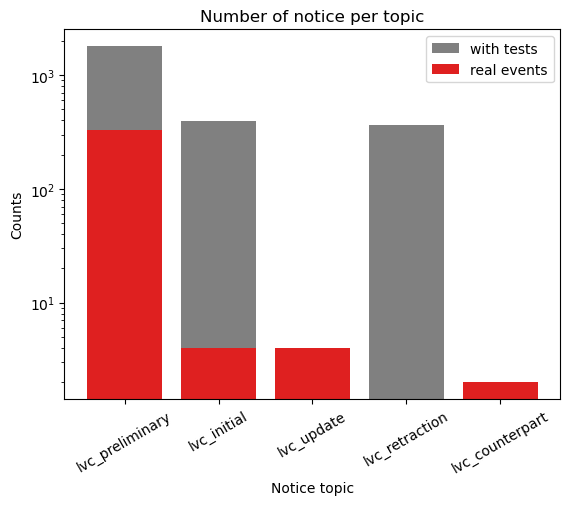

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(notices_wtests_df["topic"].value_counts(), color="grey", label="with tests")
sns.barplot(notices_df["topic"].value_counts(), color="red", label="real events")
plt.title("Number of notice per topic")
plt.ylabel("Counts")
plt.xlabel("Notice topic")
plt.xticks(rotation=30)
plt.semilogy(base=10)
plt.legend()
plt.show()

For what concerns predicted sources we can see that most of the real event were attributed a terrestrial nature , that we got no binary neutro star alert during time inteval spanned by the dataset, but only binary black-hole ones which are not that interesting, since they are expected to produce no electromagnnetic counterpart|.

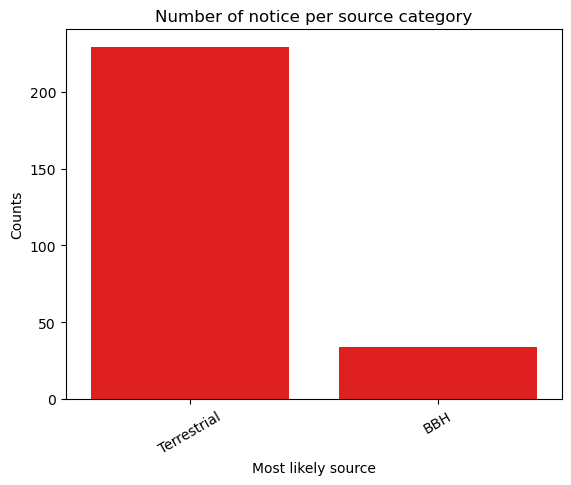

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(notices_df["source"].value_counts(), color="red")
plt.title("Number of notice per source category")
plt.ylabel("Counts")
plt.xlabel("Most likely source")
plt.xticks(rotation=30)
plt.show()

Another interesting thing to check is if all the non-test notices gets a skymap.

In [12]:
if not_on_hurry := False:  # this will take some time, so i'm disabling it by default
    import requests
    
    for skymap in notices_df["skymap"]:
        if skymap is None:
            continue
        if sc := requests.get(skymap).status_code != 200:
            raise ValueError(f"Could not reach skymap '{skymap}': HTTP requests results in status code {sc}.")
    print("All skymap are reachable via http.")
else:
    print("Skipped map availability test")

Skipped map availability test


# Localization

Let's try to plot a fucking localization map. I have found a good discussion on interacting with LVC localization [here](https://emfollow.docs.ligo.org/userguide/tutorial/skymaps.html). 

We select a map at random from our notices.

In [15]:
sample = notices_df.sample()
skymap_random = sample["skymap"].item()
sample

,filename,topic,graceId,sernum,notice_time,obs_time,skymap,delay,source,source_prob,istest
937,voe_lvc_preliminary_54082.xml,lvc_preliminary,S250307gc,2,2025-03-07 17:14:13+00:00,2025-03-07 17:09:12.726543+00:00,https://gracedb.ligo.org/api/superevents/S2503...,276,Terrestrial,0.92268,False


The skymaps are distributed in the HEALPix format and represent a probability distribution over a tasselation of the celestial sphere with constant pixel area. They are stored as (long) 1D array. Data are accompanied by a few metadata.

In [19]:
from ligo.skymap.io.fits import read_sky_map

healpix, meta = read_sky_map(skymap_random)
healpix, meta

(array([1.67835958e-09, 1.73468133e-09, 1.77097125e-09, ...,
        5.45520008e-06, 4.21195709e-06, 4.07617786e-06], shape=(786432,)),
 {'MOC': True,
  'HISTORY': ['',
   'Generated by calling the following Python function:',
   "ligo.skymap.bayestar.localize(event=..., waveform='o2-uberbank',",
   'f_low=15.0, min_distance=None, max_distance=None,',
   'prior_distance_power=None, cosmology=False, mcmc=False, chain_dump=None,',
   'enable_snr_series=True, f_high_truncate=0.95,',
   'rescale_loglikelihood=0.83)',
   '',
   'This was the command line that started the program:',
   'gwcelery worker -l info -n gwcelery-openmp-worker-14@%h -f',
   '.local/state/log/%n.log -Q openmp -c 1 --prefetch-multiplier 1'],
  'objid': 'G561360',
  'url': 'https://gracedb.ligo.org/events/G561360',
  'instruments': {'H1', 'L1', 'V1'},
  'gps_time': np.float64(1425402570.725847),
  'gps_creation_time': np.float64(1425402589.0),
  'creator': 'BAYESTAR',
  'origin': 'LIGO/Virgo/KAGRA',
  'runtime': 0.9612

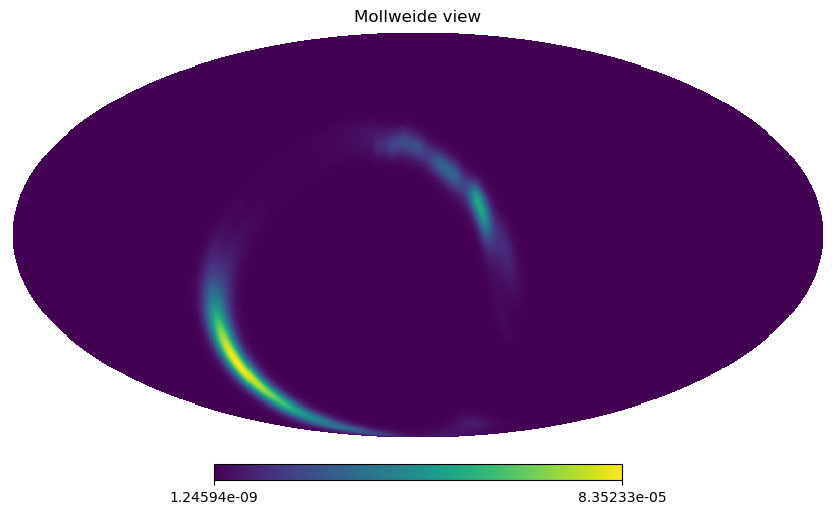

In [20]:
import healpy as hp

hp.mollview(healpix)

Let's try to quantify how large the 90% credible area is and the most likely sky location. Finding the MLP is easy, we just take the max of the probability distribution and map it to a sky coordinate.

In [21]:
import numpy as np


nside = hp.npix2nside(len(healpix))   # nside is a quantity determining the resolution of the map
pixel_area = 4 * 180 ** 2 / np.pi / len(healpix)  # you can get this also using `hp.nside2pixarea(nside, degrees=True)`
print(f"The area under a single pixel is {pixel_area} deg^2")

max_prb, argmax_prb = np.max(healpix), np.argmax(healpix)
print(f"Maximum probability value is {max_prb}, observed over pixel with index {argmax_prb}")
print(f"This probability value correspond to a probability density of {max_prb / pixel_area:.4f} deg^-2")

theta, phi = hp.pix2ang(nside, argmax_prb)
print(f"It corresponds to a sky coordinate {np.rad2deg(phi):.2f} ra, {np.rad2deg(theta):.2f} dec (in deg)")

The area under a single pixel is 0.052455852825697924 deg^2
Maximum probability value is 8.352325766479771e-05, observed over pixel with index 689444
This probability value correspond to a probability density of 0.0016 deg^-2
It corresponds to a sky coordinate 103.30 ra, 138.92 dec (in deg)


Finding the extent of the 90% most credible region is also easy.

In [22]:
def cl_area(healpix, cl: int) -> float:  # deg^2
    i = np.flipud(np.argsort(healpix))
    sorted_credible_levels = np.cumsum(healpix[i])
    credible_levels = np.empty_like(sorted_credible_levels)
    credible_levels[i] = sorted_credible_levels
    return np.sum(credible_levels <= cl) * (4 * 180 ** 2 / np.pi / len(healpix))

print(f"The area of the 90% CL region is {cl_area(healpix, 0.9):.2f} deg^2")

The area of the 90% CL region is 2348.55 deg^2


Let's try to add this information to our table.

In [24]:
if not_on_hurry := True:  # this will take some time, so i'm disabling it by default
    import requests
    from tqdm.notebook import tqdm
    
    
    mlp, area_90cl = [], []
    
    
    for i, skymap_url in tqdm(enumerate(notices_df["skymap"])):
        if skymap_url is None:
            mlp.append((None, None)); area_90cl.append(None)
            continue
        try:
            healpix, _ = read_sky_map(skymap_url)
        except e:
            print(f"Could not retrieve a skymap from url {skymap_url}")
            mlp.append((None, None)); area_90cl.append(None)
            continue
    
        nside = hp.npix2nside(len(healpix))
        max_prb, argmax_prb = np.max(healpix), np.argmax(healpix)
        theta, phi = hp.pix2ang(nside, argmax_prb)
        mlp.append((theta, phi))
        area_90cl.append(cl_area(healpix, 0.9))


0it [00:00, ?it/s]

Let's add the new information to the notice dataframe.

In [27]:
decs, ras = zip(*mlp)

localization_df = pd.DataFrame({"ra": ras, "dec": decs, "area_90cl": area_90cl})
notices_loc_df = pd.concat([notices_df.reset_index(drop=True), localization_df], axis=1)

notices_loc_df.head()

,filename,topic,graceId,sernum,notice_time,obs_time,skymap,delay,source,source_prob,istest,ra,dec,area_90cl
0,voe_lvc_preliminary_55570.xml,lvc_preliminary,S250401bi,1,2025-04-01 08:06:39+00:00,2025-04-01 08:06:13.662295+00:00,https://gracedb.ligo.org/api/superevents/S2504...,0,Terrestrial,0.927047,False,3.939263,1.112179,8061.835109
1,voe_lvc_preliminary_55347.xml,lvc_preliminary,S250328cg,2,2025-03-28 22:09:20+00:00,2025-03-28 22:04:20.962402+00:00,https://gracedb.ligo.org/api/superevents/S2503...,275,Terrestrial,0.836615,False,1.325359,1.269378,12254.316690
2,voe_lvc_preliminary_55210.xml,lvc_preliminary,S250326cp,2,2025-03-26 19:35:38+00:00,2025-03-26 19:30:27.172973+00:00,https://gracedb.ligo.org/api/superevents/S2503...,276,Terrestrial,0.892434,False,5.689850,0.747676,5705.728024
3,voe_lvc_preliminary_54623.xml,lvc_preliminary,S250316bl,2,2025-03-16 08:43:19+00:00,2025-03-16 08:37:31.698242+00:00,https://gracedb.ligo.org/api/superevents/S2503...,300,Terrestrial,0.945901,False,1.553923,1.445468,386.048849
4,voe_lvc_preliminary_55190.xml,lvc_preliminary,S250326bn,2,2025-03-26 12:18:57+00:00,2025-03-26 12:13:14.097700+00:00,https://gracedb.ligo.org/api/superevents/S2503...,276,Terrestrial,0.995619,False,4.994641,1.675152,5838.126596


Let's try to visualize statistics for the GW localization. As expected localization error improves with later notices.

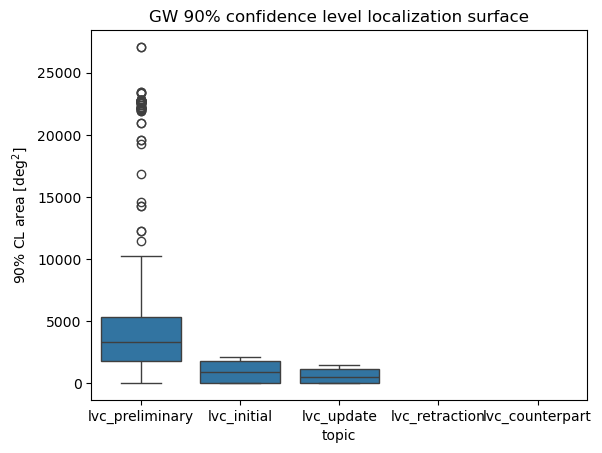

In [28]:
_df = notices_loc_df
sns.boxplot(data=notices_loc_df, x="topic", y="area_90cl")
plt.ylabel("90% CL area [deg$^2$]")
plt.title("GW 90% confidence level localization surface")
plt.show()

Luckily, BBH are better localized than terrestrial transients.

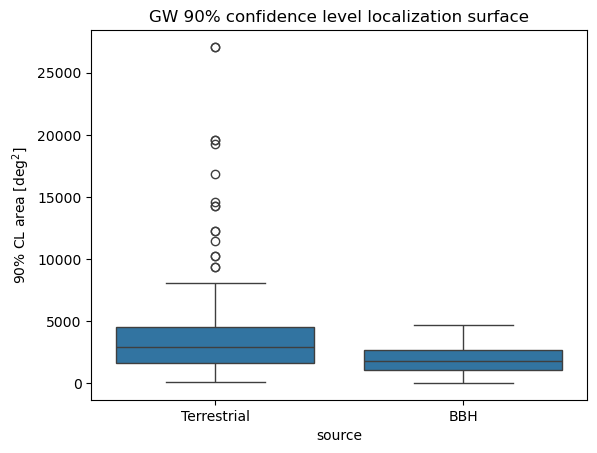

In [29]:
_df = notices_loc_df
sns.boxplot(data=notices_loc_df, x="source", y="area_90cl")
plt.ylabel("90% CL area [deg$^2$]")
plt.title("GW 90% confidence level localization surface")
plt.show()

In [35]:
notices_loc_df[notices_loc_df["source"] == "BBH"]["area_90cl"].describe()

count      34.000000
mean     1974.021667
std      1513.281030
min        14.184390
25%      1034.793330
50%      1815.759346
75%      2676.822170
max      4719.453079
Name: area_90cl, dtype: float64

50% of the notices BBH sources have localization betterr than 1815 degree squared. Which is a freaking lot.. but still.

Will continue later.